output: tensor([[-1.1588e+00,  3.6733e-01,  7.1098e-01, -2.3733e-01, -1.0129e+00,
          5.5797e-01, -8.7835e-01, -1.1446e+00, -7.6290e-01, -8.6035e-02,
          6.9335e-01,  1.6179e-01,  9.6607e-03, -4.4398e-03, -6.8012e-01,
         -1.6586e-01],
        [ 1.0179e-01, -6.7290e-01,  9.4863e-01, -4.4354e-01, -3.1697e-03,
          8.4020e-03, -1.9007e-01,  2.5528e-01,  1.5428e+00,  3.5203e-01,
          1.2877e-02, -1.0215e+00, -1.5835e+00,  1.1873e+00,  2.6503e-01,
          7.1270e-01],
        [ 4.2990e-01,  7.2088e-01,  4.6776e-01, -4.3952e-01, -1.3933e+00,
          1.6240e+00, -6.7628e-02, -6.3951e-01, -6.8561e-01,  2.5020e-01,
          8.5717e-01,  1.6535e+00, -6.3690e-01,  3.9528e-01,  4.9742e-01,
         -1.9156e+00],
        [ 4.3410e-01, -8.9631e-01,  9.4590e-01, -1.5516e+00,  1.0885e+00,
         -2.4363e+00,  3.8143e-01,  1.0093e+00,  9.9580e-02,  1.1940e+00,
          2.3586e-01,  1.3161e+00,  1.1872e+00, -2.7224e-02, -1.0050e+00,
         -4.5776e-01],
        [ 1.

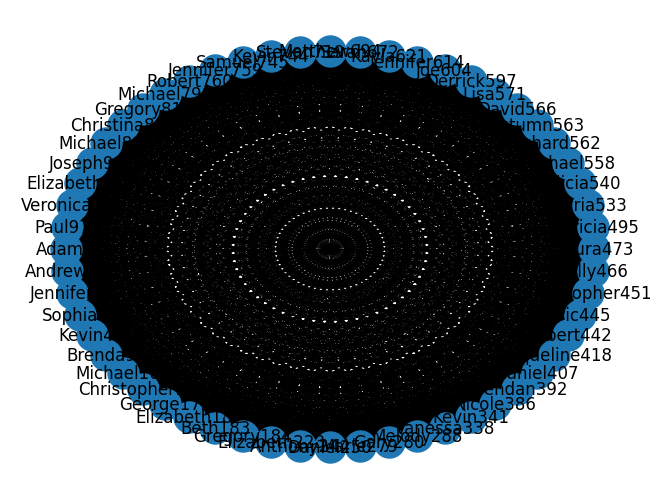

Compatibility Scores: 
Kevin49 --> Christopher451: 0.998621162222452
Kevin49 --> Kelly466: 0.9971301896371353
Kevin49 --> Eric445: 0.9949928372943446
Kevin49 --> Laura473: 0.9932202652332243
Kevin49 --> Robert442: 0.989964560409498
Kevin49 --> Patricia495: 0.989486436493078
Kevin49 --> Jacqueline418: 0.9867386317286759
Kevin49 --> Maria533: 0.9856534254055846
Kevin49 --> Felicia540: 0.9842745147756904
Kevin49 --> Daniel407: 0.9836068610869159
Kevin49 --> Michael558: 0.9817317274265174
Kevin49 --> Sophia42: 0.9803341437332376
Kevin49 --> Richard562: 0.9802709356389454
Kevin49 --> Autumn563: 0.9794248129355967
Kevin49 --> Brendan392: 0.9781503657842895
Kevin49 --> David566: 0.9779500374632173
Kevin49 --> Lisa571: 0.9758862297780837
Kevin49 --> Brenda91: 0.9730930786608052
Kevin49 --> Derrick597: 0.9730637870566898
Kevin49 --> Joe604: 0.9727296828174996
Kevin49 --> Paul974: 0.9706937237766506
Kevin49 --> Nicole386: 0.9703401988486432
Kevin49 --> Jennifer614: 0.9693014114486502
Kevin49 -->

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np
import filter_dataset
from pyvis import network as net

#df = pd.read_csv("/random_data.csv")
user_name = input("Enter user name: ")
df1 = pd.read_csv("R:/Git/Relator_Bot/test datasets/1000_location.csv")
df = filter_dataset.filter_ds(user_name, df1)
torch.manual_seed(50)

def gcn_main():
    G = nx.Graph()
    label = {}
    likes = {}
    search = {}

    for i, (user, category) in enumerate(zip(df['first_name'], df['categories'])):
        label[i] = user  # Use index as node label
        search[user] = i
        G.add_node(i, title=user, label=user)
        likes[user] = category
        
    for u in range(len(label)):
        for v in range(len(label)):
            if u != v:
                categories1 = set(likes[label[u]].split(','))
                categories2 = set(likes[label[v]].split(','))
                common_categories = categories1.intersection(categories2)
                union_categories = categories1.union(categories2)
                similarity_score = float(len(common_categories) / len(union_categories)) * 100
                if common_categories:
                    G.add_edge(u, v, weight=similarity_score)

    if G.number_of_edges() == 0:
        print("Error: The graph has no edges.")
        return

    edges = list(G.edges())

    x = torch.randn(len(label), 16)
    print("output:",x)
    edge_index = torch.tensor(edges).t().contiguous()
    data = Data(x=x, edge_index=edge_index)

    gcn_model = GCNModel(input_dim=16, hidden_dim=32, output_dim=1)

    gcn_output = gcn_model(data)

    visualize_graph(G, label, search, gcn_output)

    # return gcn_output

class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        return x 

def visualize_graph(G, label, search, gcn_output):
    pos = nx.shell_layout(G)
    nx.draw(G, pos, labels=label, with_labels=True, node_size=500)
    plt.draw()
    plt.show()
    
    # user_name = input("Enter user name: ")
    user_index = search.get(user_name)
    if user_index is not None:
        get_score(G, label, user_index, gcn_output, label)
    else:
        print("User not found.")

    nt = net.Network(notebook=True, cdn_resources='remote', height="900px", width="100%", bgcolor="#222222", font_color="white")
    nt.barnes_hut()
    nt.from_nx(G, default_node_size=100, show_edge_weights=True, edge_scaling=True)
    neighbor_map = nt.get_adj_list()
    
    for node in nt.nodes:
        neighbors = neighbor_map[node["id"]]
        neighbor_labels = "\n".join(label[i] for i in neighbors)
        node["title"] += " Neighbors: \n" + neighbor_labels
        node["value"] = len(neighbor_map[node["id"]])

    nt.prep_notebook()
    nt.show('nx.html')

def get_score(G, label, user_index, gcn_output, search):
    user_score = {}
    user_embedding = gcn_output[user_index].detach().numpy()
    for other_user_index in range(len(label)):
        if user_index != other_user_index:
            other_user_embedding = gcn_output[other_user_index].detach().numpy()
            similarity_score = float(
                1.0 / (1.0 + np.linalg.norm(user_embedding - other_user_embedding))  # Cosine similarity
            )
            user_score[other_user_index] = similarity_score

    print("Compatibility Scores: ")
    for user, score in sorted(user_score.items(), key=lambda x: x[1], reverse=True):
        print(f"{label[user_index]} --> {label[user]}: {score}")

gcn_main()
